# Ecommerce Text Classification

In [258]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [259]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,GlobalMaxPool1D,GRU
from nltk.stem import WordNetLemmatizer

### Importing Data

In [260]:
df=pd.read_csv('ecommerceDataset.csv',header=None)
df.rename(columns={0:'Class', 1: 'Description'}, inplace=True)

In [261]:
df.head()

,Class,Description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [262]:
df = df.sample(frac=1)

In [263]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50425 entries, 40926 to 13755
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class        50425 non-null  object
 1   Description  50424 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [264]:
df.isna().sum()

Class          0
Description    1
dtype: int64

In [265]:
df=df.dropna()

In [266]:
df.isna().sum()

Class          0
Description    0
dtype: int64

### Processing of Data

<AxesSubplot:xlabel='Class', ylabel='count'>

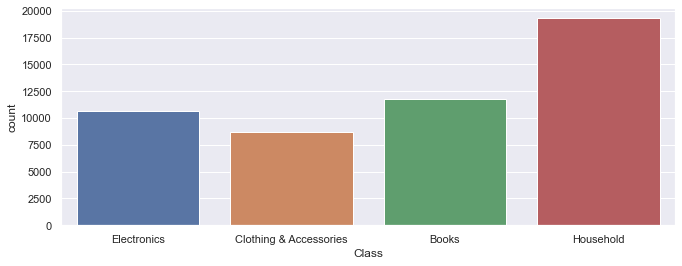

In [267]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})
sns.countplot(df['Class'])

In [268]:
from sklearn.preprocessing import LabelEncoder

label_encoder=LabelEncoder()

df['Class']=label_encoder.fit_transform(df['Class'])

In [269]:
df['Class'].unique()

array([2, 1, 0, 3])

In [270]:
df['Description']

40926    Oxyura All-in-1 Combo Card Reader with 3 Port ...
37113    RITU CREATION Women's No Rolling Down Magic Wi...
24823    A Brief History of Time: And Other Essays Amaz...
29407    All In One Science - Class 10 (2018-19 Session...
26666    Think & Grow Rich About the Author NAPOLEON HI...
                               ...                        
32069    Boys Long Sleeve Hooded Sweatshirt Set Hallowe...
8120     Polyset Laundry Basket / Basket with Lid / Bas...
15926    Shagun Orthopaedic Dual Comfort ( Hard & Soft ...
44050    Pivalo High Intensity Projector Lamp Headlight...
13755    Crock-Pot SCR400-B Crock-Pot SCR400-B 4 Quart ...
Name: Description, Length: 50424, dtype: object

### Replacing punctuations with space

In [271]:
import re

def clean_pun(text):
    #     remove urls
    text = re.sub(r'http\S+', " ", text)
    #     remove mentions
    text = re.sub(r'@\w+',' ',text)
    #     remove hastags
    text = re.sub(r'#\w+', ' ', text)
    #     remove digits
    text = re.sub(r'\d+', ' ', text)
    #     remove html tags
    text = re.sub("r<.*?>",' ', text)
    #     removing brackets
    text= re.sub(r'[\([{})\]]','',text)
    
    return text

In [272]:
df['Description_processed']=df['Description'].apply(lambda x : clean_pun(x))

In [273]:
df['Description_processed']

40926    Oxyura All-in-  Combo Card Reader with   Port ...
37113    RITU CREATION Women's No Rolling Down Magic Wi...
24823    A Brief History of Time: And Other Essays Amaz...
29407    All In One Science - Class    -  Session About...
26666    Think & Grow Rich About the Author NAPOLEON HI...
                               ...                        
32069    Boys Long Sleeve Hooded Sweatshirt Set Hallowe...
8120     Polyset Laundry Basket / Basket with Lid / Bas...
15926    Shagun Orthopaedic Dual Comfort  Hard & Soft  ...
44050    Pivalo High Intensity Projector Lamp Headlight...
13755    Crock-Pot SCR -B Crock-Pot SCR -B   Quart Manu...
Name: Description_processed, Length: 50424, dtype: object

### Stop word removal

In [274]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [275]:
len(stop_words)

179

In [276]:
print("Old length: ", len(df['Description_processed']))

Old length:  50424


In [277]:
def clean_text(text):
    text=text.split()
    text=' '.join([word for word in text if word.lower() not in stop_words])
    return text

In [278]:
df['Description_processed']=df['Description_processed'].apply(lambda x: clean_text(x))

In [279]:
#df['Description_processed']=df['Description_processed'].apply(lambda row: ''.join([word for word in row.split() if word.lower() not in stop_words]))

In [280]:
print("New length: ", len(df['Description_processed']))

New length:  50424


In [281]:
df.head()

,Class,Description,Description_processed
40926,2,Oxyura All-in-1 Combo Card Reader with 3 Port ...,Oxyura All-in- Combo Card Reader Port USB Hub ...
37113,1,RITU CREATION Women's No Rolling Down Magic Wi...,RITU CREATION Women's Rolling Magic Wire Tummy...
24823,0,A Brief History of Time: And Other Essays Amaz...,Brief History Time: Essays Amazon.com Review S...
29407,0,All In One Science - Class 10 (2018-19 Session...,One Science - Class - Session Author editorial...
26666,0,Think & Grow Rich About the Author NAPOLEON HI...,"Think & Grow Rich Author NAPOLEON HILL, born P..."


### Splitting the Data

In [282]:
from sklearn.model_selection import train_test_split
X=df['Description_processed'][:3000]
y=df['Class'][:3000]

In [283]:
## Just to make computation easy taking 6000 data

In [284]:
print(X.shape)
print(y.shape)

(3000,)
(3000,)


<AxesSubplot:xlabel='Class', ylabel='count'>

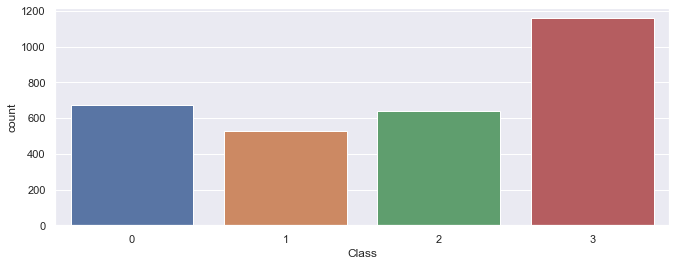

In [285]:
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize':(11,4)})
sns.countplot(y)

In [286]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

## Tokenization

In [287]:
lem=WordNetLemmatizer()

In [288]:
token=Tokenizer(num_words=20000,oov_token=lem)
token.fit_on_texts(X_train)
X_train=token.texts_to_sequences(X_train)
X_test=token.texts_to_sequences(X_test)

In [289]:
word_to_index=token.word_index
len(word_to_index)

19613

## Padding

In [290]:
X_train=pad_sequences(X_train,padding='post',truncating='post')
T=X_train.shape[1]
T

2969

In [291]:
X_test=pad_sequences(X_test,maxlen=T,padding='post',truncating='post')
X_test.shape

(900, 2969)

## LSTM Model

In [292]:
# ** Embeddindg Dimentionality **

D=32

# Its an hyper aparameter ( Length of word in sentence want to select)

# Hidden state dimentionality (M)

M=60

# Size of embedding should be (V+1 x D )
# Because first index start from 1 not from 0
# So if final index of embedding metrix is V then it should be V+1

V=len(word_to_index)

In [293]:
model=Sequential()

model.add(Input(shape=(T,)))

model.add(Embedding(V+1,D))

model.add(LSTM(M,return_sequences=True))

model.add(GlobalMaxPool1D())

model.add(Dense(M))

model.add(Dense(4,activation='softmax'))

In [294]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau

early_stop=EarlyStopping(monitor='val_accuracy',patience=10)
reduceLR=ReduceLROnPlateau(monitor='val_accuarcy',patience=8)

In [295]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [296]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),
            epochs=3,batch_size=64,callbacks=[early_stop])

Epoch 1/3
33/33 [==============================] - 187s 6s/step - loss: 1.3445 - accuracy: 0.3757 - val_loss: 1.2940 - val_accuracy: 0.3889
Epoch 2/3
33/33 [==============================] - 199s 6s/step - loss: 1.1620 - accuracy: 0.4548 - val_loss: 0.9872 - val_accuracy: 0.6133
Epoch 3/3
33/33 [==============================] - 179s 5s/step - loss: 0.7749 - accuracy: 0.7052 - val_loss: 0.6339 - val_accuracy: 0.8822
